In [1]:
import pandas as pd
import numpy as np
import glob
import os
import geopandas as gpd
import urllib
import sys
import pathlib
import glob
import matplotlib.pyplot as plt
from urllib.parse import quote
from sqlalchemy import create_engine
import configparser
import requests

import statsmodels.api as sm
#import pingouin as pg

import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from micromet import AmerifluxDataProcessor
#from tests.ffp_tests import footprint_config


from fluxdataqaqc import Data, QaQc, Plot
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models import LinearAxis, Range1d
from bokeh.io import output_notebook
output_notebook()


ModuleNotFoundError: No module named 'micromet'

In [19]:
config = configparser.ConfigParser()

config.read('../../secrets/config.ini')

from sqlalchemy import create_engine
import urllib.parse
host = config['DEFAULT']['ip']
pw = config['DEFAULT']['pw']
user = config['DEFAULT']['login']

encoded_password = urllib.parse.quote_plus(pw)

def postconn_et(encoded_password, host='localhost',user='postgres',port='5432',db='groundwater', schema = 'groundwater'):
    connection_text = "postgresql+psycopg2://{:}:{:}@{:}:{:}/{:}?gssencmode=disable".format(user,encoded_password,host,port,db)
    return create_engine(connection_text, connect_args={'options': '-csearch_path={}'.format(schema)})


engine = postconn_et(encoded_password, host=host, user=user)

In [29]:
config_path = '../../station_config/US-UTP.ini'
d = Data(config_path)
q = QaQc(d)

Converting vpd from hpa to kpa
Calculating vapor pressure from vapor pressure deficit and air temperature
Calculating dew point temperature from vapor pressure

The input data temporal frequency appears to be less than daily.
Data is being resampled to daily temporal frequency.
Linearly interpolating gaps in energy balance components up to 4 hours when Rn < 0 and up to 2 hours when Rn >= 0.
Filtering days with less then 100.0% or 48/48 sub-daily measurements


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis12\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
q.monthly_df


Missing one or more energy balance variables, cannot perform energy balance correction.
gridMET reference ET already downloaded for station at:
C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\Notebooks\Processing Workflow Notebooks\..\..\station_config\gridMET_data\US-UTP_41.0667N_-112.1000W.csv
not redownloading.
Gap filling ET with filtered ETrF x ETr (gridMET)


,VPD,es,T_SONIC,ETrF_filtered,vp,SWC_2_1_1,input_H,LW_IN,rso,ETrF,...,ET_gap,H_subday_gaps,Rn_subday_gaps,gridMET_ETr,ET,gridMET_prcp,LE_subday_gaps,ET_fill_val,gridMET_ETo,ET_fill
date,,,,,,,,,,,,,,,,,,,,,
2024-07-31,2.246626,3.411249,25.387152,0.668752,1.164624,NaN,-33.520969,NaN,362.806599,0.667269,...,1.033333,62.0,1488.0,317.646667,210.293642,3.616667,9.62069,NaN,235.703333,211.971038
2024-08-31,NaN,NaN,NaN,0.588538,NaN,NaN,NaN,NaN,322.800418,NaN,...,19.000000,836.0,1307.0,309.700000,182.287986,33.100000,820.00000,NaN,219.100000,182.728793
2024-09-30,NaN,NaN,NaN,0.508658,NaN,NaN,NaN,NaN,261.155497,NaN,...,13.000000,608.0,777.0,229.300000,113.735179,15.400000,596.00000,NaN,157.800000,115.634882
2024-10-31,NaN,NaN,NaN,0.367017,NaN,NaN,NaN,NaN,192.909854,NaN,...,8.000000,377.0,334.0,161.900000,59.412964,14.200000,359.00000,NaN,106.600000,58.526140
2024-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
d.df
d.inv_map

{'TIMESTAMP_START': 'date',
 'NETRAD': 'Rn',
 'input_LE': 'LE',
 'input_H': 'H',
 'SW_IN': 'sw_in',
 'SW_OUT': 'sw_out',
 'LW_IN': 'lw_in',
 'LW_OUT': 'lw_out',
 'RH_1_1_1': 'rh',
 'VPD': 'vpd',
 'T_SONIC': 't_avg',
 'WD': 'wd',
 'WS': 'ws',
 'SWC_2_1_1': 'theta_2'}

In [25]:
# convert to internal names, copy dataframe
df = d.df.rename(columns=d.inv_map)
# day of year mean of input energy balance components
vars_we_want = ['H', 'LE', 'Rn']
doy_means = df[vars_we_want].groupby(d.df.index.dayofyear).mean()
# create a Bokeh figure
fig = figure(x_axis_label='day of year', y_axis_label='day of year mean (w/m2)')
# arguements needed for creating interactive plots
plt_vars = vars_we_want
colors = ['red', 'blue', 'black', 'green']
x_name = 'date'
source = ColumnDataSource(doy_means)
Plot.add_lines(fig, doy_means, plt_vars, colors, x_name, source, labels=vars_we_want,
    x_axis_type=None)
show(fig)

In [2]:
station = 'US-UTP'
startdate = '2020-01-01'

headdict = {'Accept-Profile': 'groundwater','Content-Type': 'application/json'}

params = {'stationid':f'eq.{station}',
         'datetime_start':f'gte.{startdate}'
         }

resp_ed = requests.get("https://ugs-koop-umfdxaxiyq-wm.a.run.app/amfluxeddy",headers=headdict,params=params)
resp_met = requests.get("https://ugs-koop-umfdxaxiyq-wm.a.run.app/amfluxmet",headers=headdict,params=params)

In [11]:
resp_met

<Response [200]>

In [3]:
data_ed = pd.DataFrame(resp_ed.json())
data_met = pd.DataFrame(resp_met.json())

if len(data_ed) > 0:
    data_ed['datetime_start'] = pd.to_datetime(data_ed['datetime_start'])
    data_ed = data_ed.set_index(['stationid','datetime_start'])

if len(data_met) > 0:
    data_met['datetime_start'] = pd.to_datetime(data_met['datetime_start'])
    data_met = data_met.set_index(['stationid','datetime_start'])

if len(data_ed) > 0 and len(data_met) > 0:
    all_data = pd.concat([data_ed,data_met],axis=1)

In [4]:
data_ed.replace(-9999,np.nan,inplace=True)

timestamp_start  timestamp_end        co2  \
stationid datetime_start                                                   
US-UTP    2023-01-26 17:00:00     202301261700   202301261730 -9999.0000   
          2023-01-26 17:30:00     202301261730   202301261800   406.2625   
          2023-01-26 18:00:00     202301261800   202301261830   406.2360   
          2023-01-26 18:30:00     202301261830   202301261900   406.8281   
          2023-01-26 19:00:00     202301261900   202301261930   408.2220   
...                                        ...            ...        ...   
          2024-11-01 03:30:00     202411010330   202411010400 -9999.0000   
          2024-11-01 04:00:00     202411010400   202411010430 -9999.0000   
          2024-11-01 04:30:00     202411010430   202411010500 -9999.0000   
          2024-11-01 05:00:00     202411010500   202411010530 -9999.0000   
          2024-11-01 05:30:00     202411010530   202411010600 -9999.0000   

                                 co2_sigma          h2o    h2o_sigma  \
stationid datetime_start                                               
US-UTP    2023-01-26 17:00:00 -9999.000000 -9999.000000 -9999.000000   
          2023-01-26 17:30:00     0.626717     3.538518     0.061771   
          2023-01-26 18:00:00     0.335480     3.644652     0.053017   
          2023-01-26 18:30:00     0.611918     3.665830     0.042666   
          2023-01-26 19:00:00     0.431019     3.696614     0.044724   
...                                    ...          ...          ...   
          2024-11-01 03:30:00 -9999.000000 -9999.000000 -9999.000000   
          2024-11-01 04:00:00 -9999.000000 -9999.000000 -9999.000000   
          2024-11-01 04:30:00 -9999.000000 -9999.000000 -9999.000000   
          2024-11-01 05:00:00 -9999.000000 -9999.000000 -9999.000000   
          2024-11-01 05:30:00 -9999.000000 -9999.000000 -9999.000000   

                                        fc  fc_ssitc_test           le  \
stationid datetime_start                                                 
US-UTP    2023-01-26 17:00:00 -9999.000000          -9999 -9999.000000   
          2023-01-26 17:30:00     0.332273              1 -9999.000000   
          2023-01-26 18:00:00     0.323838              1 -9999.000000   
          2023-01-26 18:30:00     0.274951              1 -9999.000000   
          2023-01-26 19:00:00     0.383618          -9999     2.952237   
...                                    ...            ...          ...   
          2024-11-01 03:30:00 -9999.000000          -9999 -9999.000000   
          2024-11-01 04:00:00 -9999.000000          -9999 -9999.000000   
          2024-11-01 04:30:00 -9999.000000          -9999 -9999.000000   
          2024-11-01 05:00:00 -9999.000000          -9999 -9999.000000   
          2024-11-01 05:30:00 -9999.000000          -9999 -9999.000000   

                               le_ssitc_test  ...  rh_1_3_1  t_dp_1_3_1  \
stationid datetime_start                      ...                         
US-UTP    2023-01-26 17:00:00          -9999  ...   -9999.0  -9999.0000   
          2023-01-26 17:30:00              1  ...   -9999.0  -9999.0000   
          2023-01-26 18:00:00              1  ...   -9999.0  -9999.0000   
          2023-01-26 18:30:00              1  ...   -9999.0  -9999.0000   
          2023-01-26 19:00:00          -9999  ...   -9999.0  -9999.0000   
...                                      ...  ...       ...         ...   
          2024-11-01 03:30:00          -9999  ...   -9999.0   -109.1214   
          2024-11-01 04:00:00          -9999  ...   -9999.0   -109.4099   
          2024-11-01 04:30:00          -9999  ...   -9999.0   -110.7138   
          2024-11-01 05:00:00          -9999  ...   -9999.0   -112.3313   
          2024-11-01 05:30:00          -9999  ...   -9999.0   -111.6402   

                               ta_1_4_1     pblh_f     ts_2_1_1   swc_2_1_1  \
stationid datetime_start                                                      
US-UTP  

<Axes: xlabel='datetime_start'>

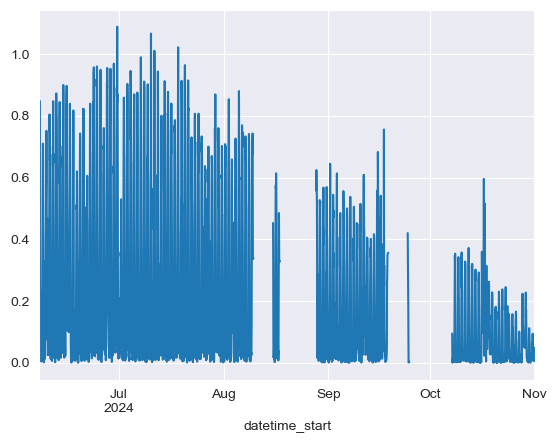

In [16]:
sql = "SELECT * FROM groundwater.amfluxeddy WHERE stationid = 'US-UTP' and datetime_start >= '2024-06-07 9:00'"
data = pd.read_sql(sql,engine)
data.replace(-9999,np.nan,inplace=True)
data.set_index('datetime_start',inplace=True)
#data = data.loc[pd.to_datetime('2024-06-07 9:00'):]

# Replace values in column 'A' below 0 with NaN
data['et'] = np.where(data['et'] < 0, np.nan, data['et'])
hrly = data.resample('1h').mean(numeric_only=True)
hrly = hrly.interpolate(method='time',limit=4)
# Compute daily cumulative sum
hrly['et_cumsum'] = hrly.groupby(hrly.index.date)['et'].cumsum()

hrly['et'].plot()

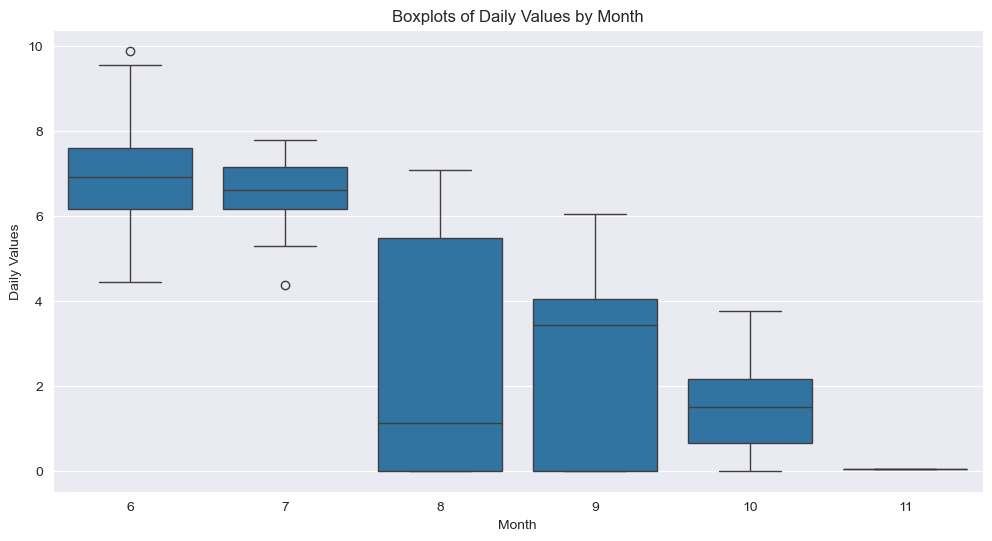

In [17]:
# Compute daily cumulative sum
dlyet = hrly.groupby(pd.Grouper(level=0,freq='D'))['et'].sum().to_frame()
dlyet['month'] = dlyet.index.month
import seaborn as sns
# Plot boxplots by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='et', data=dlyet)
plt.title('Boxplots of Daily Values by Month')
plt.xlabel('Month')
plt.ylabel('Daily Values')
#plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


In [46]:
6*30*0.0393701

7.086618

In [28]:
stat_config = configparser.ConfigParser()
stat_config.read('../../station_config/US-UTP.ini')

latitude = stat_config['METADATA']['station_latitude']
longitude = stat_config['METADATA']['station_longitude']

crs = 4326

import pygridmet as gridmet
coords = (longitude, latitude)
dates = ("2024-06-07", "2024-12-27")

var = ['sph', 'srad', 'etr', 'pet', 'vs', 'tmmx', 'tmmn', 'vpd']

gridmet_data = gridmet.get_bycoords(coords, dates, variables=var, crs=crs)

<table class="table">
<thead>
<tr class="row-odd"><th class="head"><p>Variable</p></th>
<th class="head"><p>Abbr</p></th>
<th class="head"><p>Unit</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Precipitation</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">pr</span></code></p></td>
<td><p>mm</p></td>
</tr>
<tr class="row-odd"><td><p>Maximum Relative Humidity</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">rmax</span></code></p></td>
<td><p>%</p></td>
</tr>
<tr class="row-even"><td><p>Minimum Relative Humidity</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">rmin</span></code></p></td>
<td><p>%</p></td>
</tr>
<tr class="row-odd"><td><p>Specific Humidity</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">sph</span></code></p></td>
<td><p>kg/kg</p></td>
</tr>
<tr class="row-even"><td><p>Surface Radiation</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">srad</span></code></p></td>
<td><p>W/m2</p></td>
</tr>
<tr class="row-odd"><td><p>Wind Direction</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">th</span></code></p></td>
<td><p>Degrees Clockwise from north</p></td>
</tr>
<tr class="row-even"><td><p>Minimum Air Temperature</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">tmmn</span></code></p></td>
<td><p>K</p></td>
</tr>
<tr class="row-odd"><td><p>Maximum Air Temperature</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">tmmx</span></code></p></td>
<td><p>K</p></td>
</tr>
<tr class="row-even"><td><p>Wind Speed</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vs</span></code></p></td>
<td><p>m/s</p></td>
</tr>
<tr class="row-odd"><td><p>Burning Index</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">bi</span></code></p></td>
<td><p>Dimensionless</p></td>
</tr>
<tr class="row-even"><td><p>Fuel Moisture (100-hr)</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">fm100</span></code></p></td>
<td><p>%</p></td>
</tr>
<tr class="row-odd"><td><p>Fuel Moisture (1000-hr)</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">fm1000</span></code></p></td>
<td><p>%</p></td>
</tr>
<tr class="row-even"><td><p>Energy Release Component</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">erc</span></code></p></td>
<td><p>Dimensionless</p></td>
</tr>
<tr class="row-odd"><td><p>Reference Evapotranspiration (Alfalfa)</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">etr</span></code></p></td>
<td><p>mm</p></td>
</tr>
<tr class="row-even"><td><p>Reference Evapotranspiration (Grass)</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">pet</span></code></p></td>
<td><p>mm</p></td>
</tr>
<tr class="row-odd"><td><p>Vapor Pressure Deficit</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">vpd</span></code></p></td>
<td><p>kPa</p></td>
</tr>
</tbody>
</table>

In [29]:
data

,sph (kg/kg),srad (W/m2),etr (mm),pet (mm),vs (m/s),tmmx (K),tmmn (K),vpd (kPa)
time,,,,,,,,
2024-06-07,902.0,3114.0,78.0,63.0,21.0,853.0,797.0,207.0
2024-06-08,797.0,3293.0,80.0,65.0,19.0,858.0,791.0,225.0
2024-06-09,868.0,3117.0,101.0,75.0,32.0,883.0,794.0,254.0
2024-06-10,857.0,3275.0,87.0,67.0,32.0,834.0,772.0,175.0
2024-06-11,713.0,3322.0,82.0,65.0,20.0,859.0,770.0,227.0
...,...,...,...,...,...,...,...,...
2024-12-23,407.0,318.0,12.0,8.0,26.0,610.0,616.0,23.0
2024-12-24,368.0,845.0,20.0,12.0,41.0,610.0,635.0,32.0
2024-12-25,433.0,406.0,8.0,6.0,36.0,571.0,632.0,10.0


In [ ]:
data_ed.loc[station,'co2'].replace(-9999,np.nan).plot()

In [ ]:
imp_mean = IterativeImputer(random_state=0, max_iter=30, missing_values=np.nan,
                            sample_posterior=True,n_nearest_features=100,)
imp_mean.fit(data)
#X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
new_utd = pd.DataFrame(imp_mean.transform(data), columns=data.columns)
data['imp_LE'] = new_utd['LE']

* footprint
* import opentet

* Import remote sensing data to impute
